In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import minimize
from scipy.stats import norm, poisson

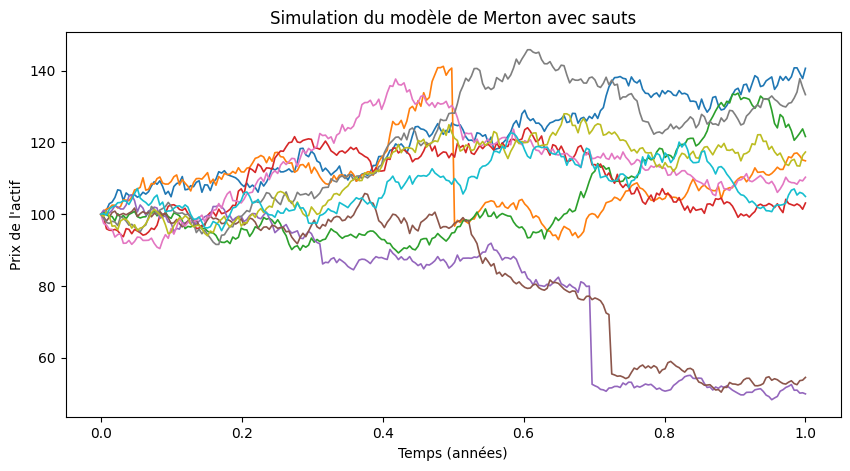

In [ ]:
# Paramètres du modèle
S0 = 100      # Prix initial de l'actif
mu = 0.1      # Rendement moyen
sigma = 0.2   # Volatilité
lambda_ = 0.5 # Intensité du processus de Poisson (nombre moyen de sauts par an)
mu_J = -0.1   # Moyenne des sauts log-normaux
sigma_J = 0.2 # Écart-type des sauts log-normaux
T = 1.0       # Horizon temporel (en années)
N = 252       # Nombre de pas de temps (jours de bourse)
M = 10        # Nombre de trajectoires simulées

dt = T / N  # Pas de temps
t = np.linspace(0, T, N)

# Simulation des trajectoires du prix
S = np.zeros((M, N))
S[:, 0] = S0

for m in range(M):
    W = np.random.normal(0, np.sqrt(dt), N)  # Bruit brownien
    N_t = np.random.poisson(lambda_ * dt, N) # Processus de Poisson
    J_t = np.random.normal(mu_J, sigma_J, N) * N_t  # Sauts log-normaux
    
    for i in range(1, N):
        dS = mu * S[m, i-1] * dt + sigma * S[m, i-1] * W[i] + S[m, i-1] * J_t[i]
        S[m, i] = S[m, i-1] + dS

# Affichage des trajectoires
plt.figure(figsize=(10, 5))
for m in range(M):
    plt.plot(t, S[m, :], lw=1.2)
plt.xlabel("Temps (années)")
plt.ylabel("Prix de l'actif")
plt.title("Simulation du modèle de Merton avec sauts")
plt.show()


In [14]:
# Read the file with tab separator
df = pd.read_csv("Data/CAC40 daily 10y/AIRBUS_2025-03-08_Data_1d_10y.txt", sep='\t')
# Convert first column to datetime and set as index
df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

In [15]:
df.head()

,date,ouv,haut,bas,clot,vol,devise,Unnamed: 7
date,,,,,,,,
2015-03-09,09/03/2015 00:00,58.97,59.49,58.42,58.88,1917367,EUR,NaN
2015-03-10,10/03/2015 00:00,58.58,59.16,57.92,58.88,3101036,EUR,NaN
2015-03-11,11/03/2015 00:00,59.10,61.53,59.04,61.43,3256951,EUR,NaN
2015-03-12,12/03/2015 00:00,61.50,62.48,61.40,62.08,3119145,EUR,NaN
2015-03-13,13/03/2015 00:00,62.12,63.56,61.85,63.56,3358370,EUR,NaN


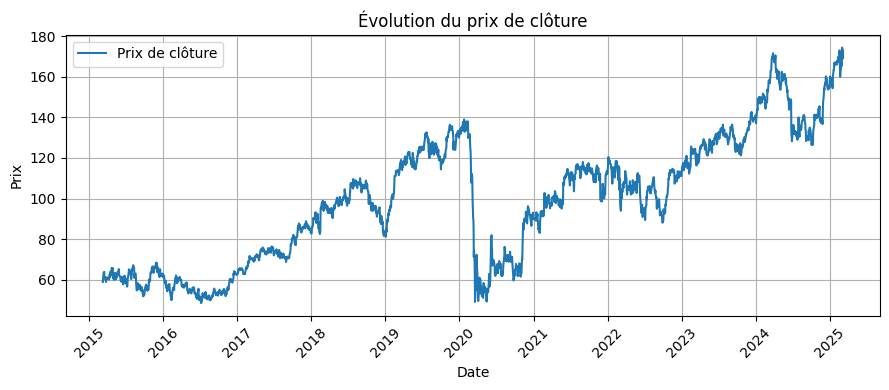

In [19]:
plt.figure(figsize=(9, 4))
plt.plot(df.index, df['clot'], label='Prix de clôture')
plt.title('Évolution du prix de clôture')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:

# Fonction de vraisemblance pour calibrer le modèle de Merton
def log_likelihood(params, returns, dt):
    mu, sigma, lambda_, mu_J, sigma_J = params
    
    # Probabilité qu'un saut se produise
    N_t = poisson.pmf(1, lambda_ * dt)
    
    # Densité de probabilité des rendements avec et sans saut
    normal_part = norm.logpdf(returns, loc=mu * dt, scale=sigma * np.sqrt(dt))
    jump_part = norm.logpdf(returns, loc=mu * dt + mu_J, scale=np.sqrt(sigma**2 * dt + sigma_J**2))
    
    # Combinaison des probabilités (mixte entre rendements normaux et sautés)
    log_likelihood = np.log((1 - N_t) * np.exp(normal_part) + N_t * np.exp(jump_part))
    
    return -np.sum(log_likelihood)  # On minimise la log-vraisemblance négative

# Chargement des prix historiques (exemple fictif)
cours = np.array(df["clot"])
returns = np.log(cours[1:] / cours[:-1])  # Rendements logarithmiques

# Initialisation des paramètres initiaux
init_params = [0.1, 0.2, 4.4, -0.1, 0.2]
dt = 1 / 252  # Période en années (1 jour de bourse)

# Calibration avec la maximisation de la vraisemblance
result = minimize(log_likelihood, init_params, args=(returns, dt), method='L-BFGS-B',
                  bounds=[(-1, 1), (0.01, 1), (0, 50), (-1, 1), (0.01, 1)])

# Affichage des paramètres estimés
mu_hat, sigma_hat, lambda_hat, mu_J_hat, sigma_J_hat = result.x
print(f"\nParamètres estimés du modèle de Merton avec sauts :")
print(f"Rendement moyen (mu) : {mu_hat:.4f}")
print(f"Volatilité (sigma) : {sigma_hat:.4f}")
print(f"Intensité des sauts (lambda) : {lambda_hat:.4f}")
print(f"Moyenne des sauts (mu_J) : {mu_J_hat:.4f}")
print(f"Écart-type des sauts (sigma_J) : {sigma_J_hat:.4f}")


Paramètres estimés du modèle de Merton avec sauts :
Rendement moyen (mu) : 0.1256
Volatilité (sigma) : 0.2412
Intensité des sauts (lambda) : 25.2700
Moyenne des sauts (mu_J) : -0.0009
Écart-type des sauts (sigma_J) : 0.0528


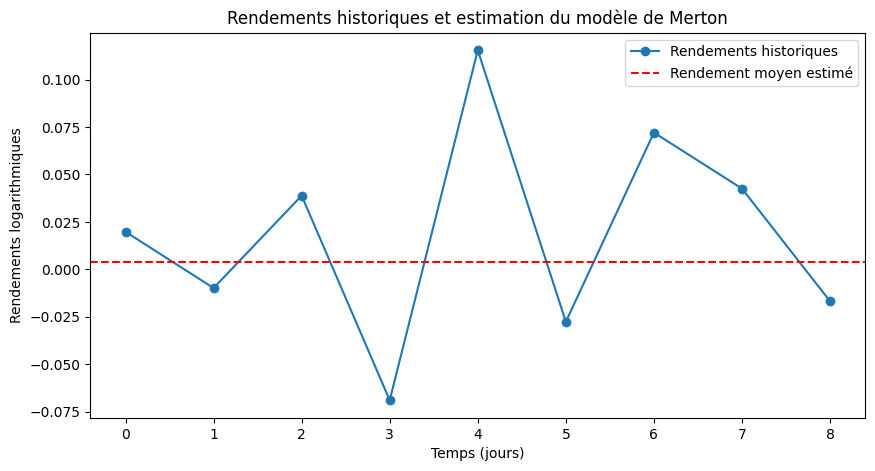

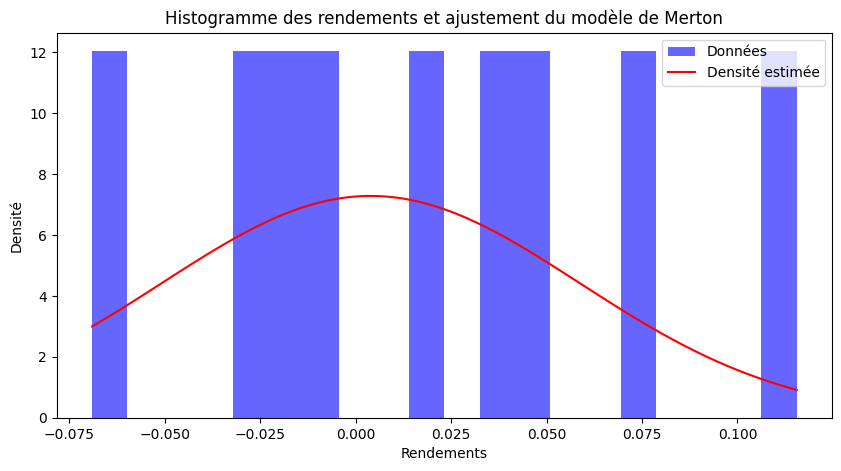

In [3]:
# Affichage des rendements historiques
plt.figure(figsize=(10, 5))
plt.plot(returns, marker='o', linestyle='-', label='Rendements historiques')
plt.axhline(y=mu_hat * dt, color='r', linestyle='--', label='Rendement moyen estimé')
plt.xlabel("Temps (jours)")
plt.ylabel("Rendements logarithmiques")
plt.title("Rendements historiques et estimation du modèle de Merton")
plt.legend()
plt.show()

# Histogramme des rendements et ajustement normal
plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(returns, bins=20, density=True, alpha=0.6, color='b', label='Données')

# Ajustement d'une distribution normale basée sur les paramètres estimés
x = np.linspace(min(returns), max(returns), 100)
pdf = (1 - lambda_hat * dt) * norm.pdf(x, mu_hat * dt, sigma_hat * np.sqrt(dt)) + \
      (lambda_hat * dt) * norm.pdf(x, mu_hat * dt + mu_J_hat, np.sqrt(sigma_hat**2 * dt + sigma_J_hat**2))
plt.plot(x, pdf, 'r-', label='Densité estimée')

plt.xlabel("Rendements")
plt.ylabel("Densité")
plt.title("Histogramme des rendements et ajustement du modèle de Merton")
plt.legend()
plt.show()
